# SHO Analysis

## Info Cell 
Where is the data saved, where do you want to save the results,and how many acquisitions

In [6]:
fftFileName= 'D:\\Dropbox (GaTech)\\Dropbox (GaTech)\\ME-DboxMgmt-Bassiri-Gharb\\BE_Active\\Kerisha\\M1B\\10-02-2019\\A1\\Measurements\\02_SSPFM_10VN\\RT_SSPFM_10VN.h5'
waveSpecFileName= 'D:\\Dropbox (GaTech)\\Dropbox (GaTech)\\ME-DboxMgmt-Bassiri-Gharb\\BE_Active\\Kerisha\\M1B\\10-02-2019\\A1\\Measurements\\02_SSPFM_10VN\\BESSPFM_gen.csv'
saveName= 'D:\\Dropbox (GaTech)\\Dropbox (GaTech)\\ME-DboxMgmt-Bassiri-Gharb\\BE_Active\\Kerisha\\M1B\\10-02-2019\\A1\\Measurements\\02_SSPFM_10VN\\shofit_test.csv'
numAcq=2500
grid=50

smooth = False

<IPython.core.display.Javascript object>


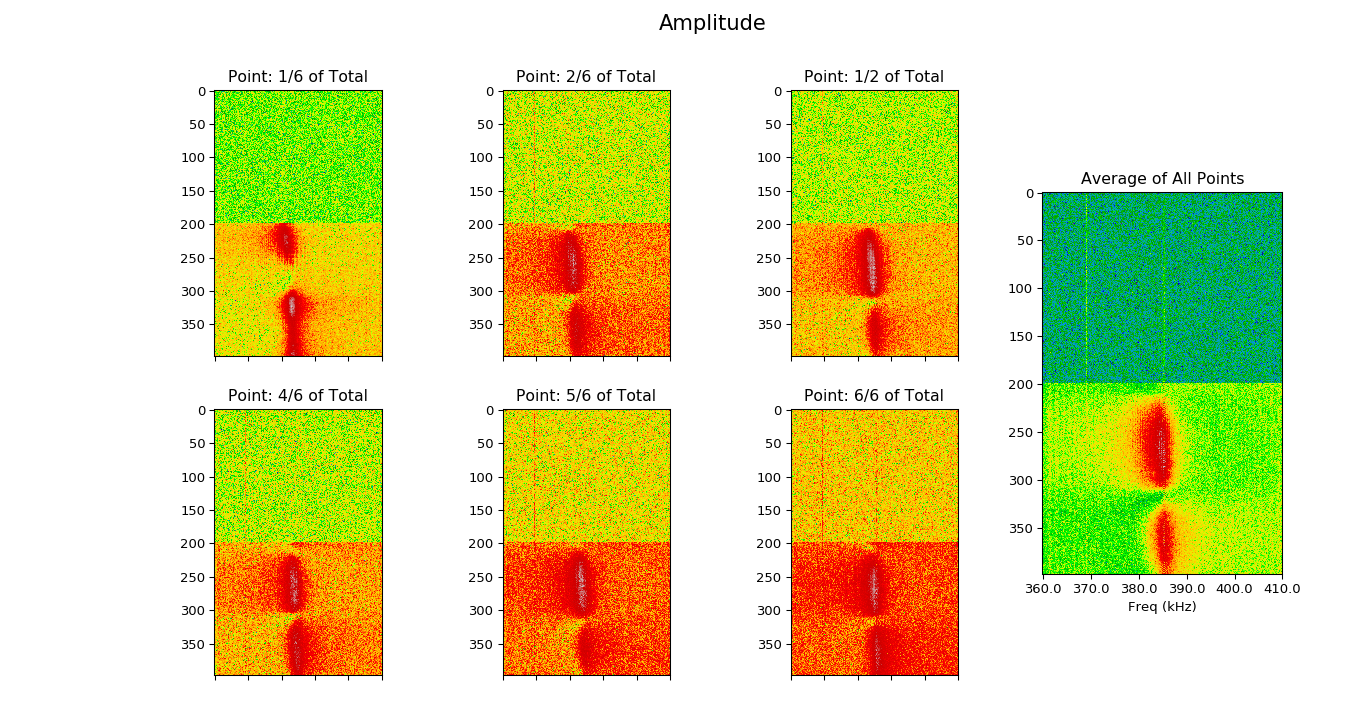

<IPython.core.display.Javascript object>


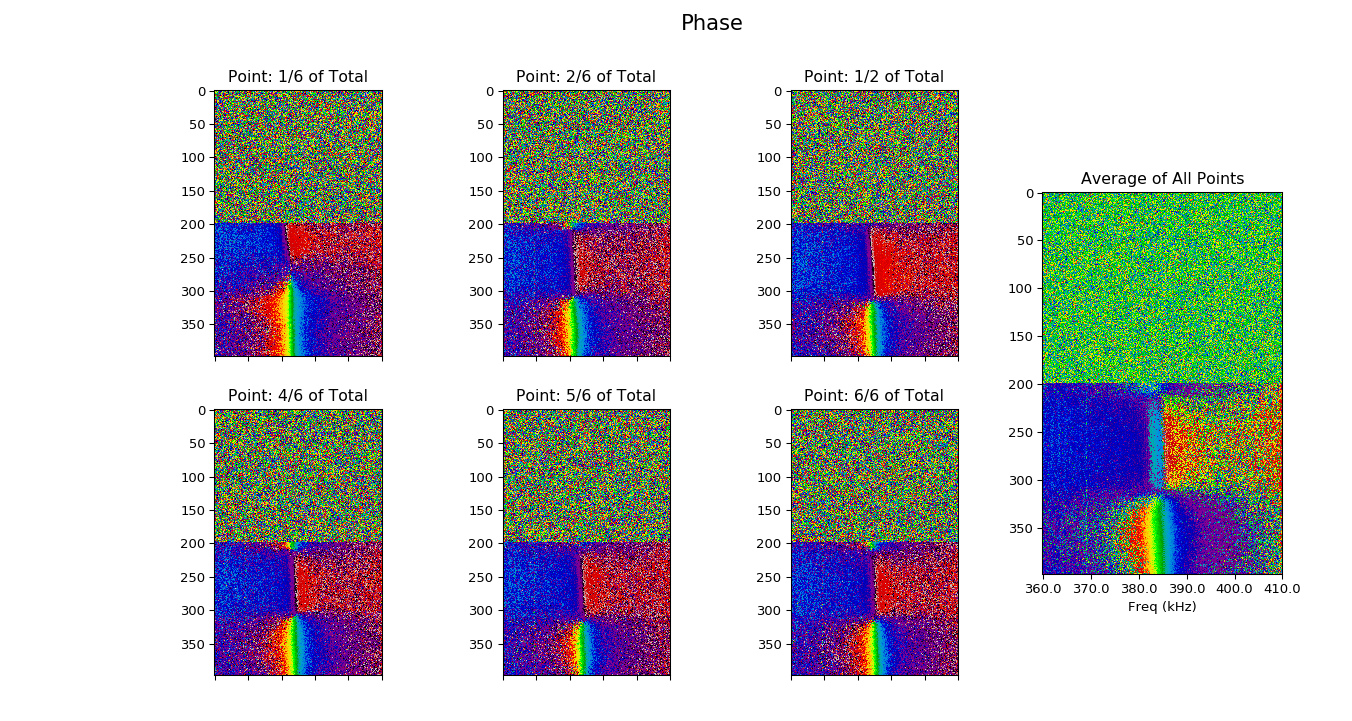

In [8]:
getfreqinfo(fftFileName)

Based off of the above plots. Select appropraite frequency limits for the fitting.

In [9]:
low=370000
high=400000

## Run

In [10]:
#Run Fitting
shoPartial=partial(shoFitAcq,fftFileName=fftFileName,chirpMap=chirpMap,grid=grid,lowFreq=low,highFreq=high,smooth=smooth)
results = shoPartial(0)

for i in np.arange(1,numAcq):
    res = shoPartial(i)
    results=pd.concat([results,res],axis=0)
    sys.stderr.write('\rdone {0:%}'.format(i/numAcq))

done 0.240000%

KeyboardInterrupt: 

In [ ]:
# You can run this cell to remove the "dead" chirps, or really anything that has a plotgroup = to clip_val
clip_val = 9
mask = results['PlotGroup']!=clip_val
results = results[mask.values]

In [ ]:
#Save Fitting
results.to_csv(saveName)

Import Cell: Collapsed Below

In [1]:
%matplotlib notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from nptdms import TdmsFile       #For reading LabView files
import numpy as np                #for numerical operations
import pandas as pd               #for data reading/structure
import matplotlib.pyplot as plt          #Used for plotting
from scipy.optimize import curve_fit
import scipy.signal as signal
from functools import partial
import multiprocessing
from contextlib import contextmanager
import sys

numProcesses=8

ParallelFitting Funcion: Collapsed Below

In [2]:
def parallelFitting(acqs):
    pool = multiprocessing.Pool(processes=numProcesses)
    shoPartial=partial(shoFitAcq,fftFileName=fftFileName,chirpMap=chirpMap,grid=grid,lowFreq=low,highFreq=high,smooth=smooth)
    result=pool.imap_unordered(shoPartial, acqs)
    return result

In [ ]:
if __name__ == '__main__':

    pool = multiprocessing.Pool(processes=numProcesses)
    shoPartial=partial(shoFitAcq,fftFileName=fftFileName,chirpMap=chirpMap,grid=grid,lowFreq=low,highFreq=high,smooth=smooth)
    
    results = shoPartial(0)
    
    result = pool.imap(shoPartial, np.arange(1,numAcq))
    
    for i, res in enumerate(result):
        results=pd.concat([results,res],axis=0)
        sys.stderr.write('\rdone {0:%}'.format(i/numAcq))
    #for res in parallelFitting(np.arange(0,numAcq)):
    #    try:
    #        print(i)
    #        results=pd.concat([results,res],axis=0)
    #    except:
    #        results=res
            


In [3]:
# Moved so that the notebook works...

def limFitData(data, freq, guess):

    #Get guesses for individual parameters
    qGuess=np.abs(guess[3])
    resGuess=guess[2]

    #Get standard deviation from Q
    std=resGuess/(2.355*qGuess)

    #We can use the standard deviation to pull out the 
    #data for just the resonance. 
    #If we pull out just the data within two standard deviatons
    #the resonance we will have about %95 of the peak.
    upperLim=resGuess+1*std
    lowerLim=resGuess-1*std

    #We cant extend past the data we actuall have!!
    if upperLim > np.max(freq):
        upperLim=np.max(freq)
    if lowerLim < np.min(freq):
        lowerLim=np.min(freq)

    #Get the indicies where the data is within this range
    indicies=np.where(np.logical_and(freq>lowerLim,freq<upperLim))

    return data[indicies], freq[indicies]

In [ ]:
from lmfit import Model, Parameters
from scipy.optimize import leastsq

def complexGaus(x,a,phi,res,Q):
    func=a*np.exp(1j*phi)*res**2 / (x**2-1j*x*res/Q-res**2)
    return func

def residuals(x,a,phi,res,Q):
    #a=params['a']
    #phi=params['phi']
    #res=params['res']
    #Q=params['Q']
    fit=complexGaus(x,a,phi,res,Q)
    ampRes=np.abs(fit)
    phaseRes=np.angle(fit)
    return np.concatenate((ampRes,phaseRes))

def residualsRI(x,a,phi,res,Q):
    #a=params['a']
    #phi=params['phi']
    #res=params['res']
    #Q=params['Q']
    fit=complexGaus(x,a,phi,res,Q)
    realRes=np.real(fit)
    imagRes=np.imag(fit)
    return np.concatenate((realRes,imagRes))

def resB(x,a,phi,res,Q):
    fit=complexGaus(x,a,phi,res,Q)
    amp=np.abs(fit)
    return amp

def resC(x,a,phi,res,Q):
    fit=complexGaus(x,a,phi,res,Q)
    phase=np.angle(fit)
    return phase

def resReal(x,a,phi,res,Q):
    fit=complexGaus(x,a,phi,res,Q)
    real=np.real(fit)
    return real

def resImag(x,a,phi,res,Q):
    fit=complexGaus(x,a,phi,res,Q)
    imag=np.imag(fit)
    return imag

saveReport='D:\\Data\\07-12-2018\\SSPFM\\fitReport.txt'

store=pd.HDFStore(fftFileName)
spec=store['Acq'+str(0)]
chirpData=spec.xs(259)
freq=chirpData.index.values
chirpData=(10**6)*chirpData.values

xGuess=be.getSHOguess(chirpData, freq)
xGuess=np.array(xGuess,dtype='float64')
print(xGuess)
chirpData=be.savitzky_golay(chirpData,53,3)
trimData,trimFreq=limFitData(chirpData, freq, xGuess)

print(chirpData.shape)
# print(trimData.shape)

#trimData=chirpData
#trimFreq=freq

#dataAmp=trimData.real**2+trimData.imag**2
dataAmp=np.abs(trimData)
dataPhase=np.unwrap(np.angle(trimData))
data=np.concatenate((dataAmp,dataPhase))

dataReal=np.real(trimData)
dataImag=np.imag(trimData)
dataRI=np.concatenate((dataReal,dataImag))

model = Model(resB)
params = model.make_params(a=xGuess[0], phi=xGuess[1], res=xGuess[2], Q=xGuess[3])
resultAmp = model.fit(dataAmp, params, x=trimFreq)

print(resultAmp.fit_report())

plt.plot(trimFreq, dataAmp,'r.', label='data')
plt.plot(trimFreq, resultAmp.best_fit, 'k-', label='fit')
plt.show()

a=resultAmp.params['a'].value
aErr=resultAmp.params['a'].stderr
print(aErr)
res=resultAmp.params['res'].value
Q=resultAmp.params['Q'].value

model = Model(resC)
params = model.make_params(a=a, phi=xGuess[1], res=res, Q=Q)
params['a'].vary = False
params['res'].vary = False
params['Q'].vary = False
result = model.fit(dataPhase, params, x=trimFreq)

print(result.fit_report())

plt.plot(trimFreq, dataPhase,'r.', label='data')
plt.plot(trimFreq, result.best_fit, 'k-', label='fit')
plt.show()

maxAmpVal=np.max(dataAmp)

model = Model(residualsRI)
params = Parameters()
params.add('maxAmp', value=maxAmpVal, vary=False)
params.add('a', value=xGuess[0], min=0, max=maxAmpVal)
params.add('phi', value=xGuess[1])
params.add('res', value=xGuess[2], min=np.min(trimFreq), max=np.max(trimFreq))
params.add('Q', value=xGuess[3], expr='maxAmp/a', max=1000)

#model.make_params(a=xGuess[0], phi=xGuess[1], res=xGuess[2], Q=xGuess[3])
#params['Q'].min = 1
result = model.fit(dataRI, params, x=trimFreq, tol=1e-10)

length=int(len(result.best_fit)/2)

resulting=result.best_fit[:length]+1j*result.best_fit[length:]
resultAmp=np.abs(resulting)
resultPhase=np.angle(resulting)

print(result.fit_report())
print("===============================================", file=open(saveReport, "a"))
print("This is the Acq/Chirp Num", file=open(saveReport, "a"))
print("===============================================", file=open(saveReport, "a"))
print(result.fit_report(), file=open(saveReport, "a"))
#plt.plot(trimFreq, dataImag,'r.', label='data')
#plt.plot(trimFreq, result.best_fit[length:], 'k-', label='fit')
#plt.show()
#plt.plot(trimFreq, dataReal,'r.', label='data')
#plt.plot(trimFreq, result.best_fit[:length], 'k-', label='fit')
#plt.show()

plt.plot(trimFreq, dataAmp,'r-', label='data')
plt.plot(trimFreq, resultAmp, 'k-', label='fit')
plt.show()
plt.plot(trimFreq, dataPhase,'r-', label='data')
plt.plot(trimFreq, np.unwrap(resultPhase), 'k-', label='fit')
plt.show()

#Fit it
#result=leastsq(residuals,xGuess,args=(trimData,trimFreq),maxfev=5000)
#pfit, pcov, infodict, errmsg, success = leastsq(residuals, xGuess, args=(trimData,trimFreq),full_output=1)
#print(pfit)
#plt.plot(freq,np.abs(chirpData))
#plt.plot(trimFreq,np.abs(trimData))
#plt.plot(freq,np.abs(complexGaus(freq,*pfit)))
#plt.show()

In [ ]:
from lmfit import Model, Parameters
from scipy.optimize import leastsq

def complexGaus(x,a,phi,res,Q):
    func=a*np.exp(1j*phi)*res**2 / (x**2-1j*x*res/Q-res**2)
    return func

def residuals(x,a,phi,res,Q):
    #a=params['a']
    #phi=params['phi']
    #res=params['res']
    #Q=params['Q']
    fit=complexGaus(x,a,phi,res,Q)
    ampRes=np.abs(fit)
    phaseRes=np.angle(fit)
    return np.concatenate((ampRes,phaseRes))

def resAmp(x,a,res,Q):
    fit=complexGaus(x,a,0,res,Q)
    amp=np.abs(fit)
    return amp

def resPhase(x,phi,res,Q):
    fit=complexGaus(x,1,phi,res,Q)
    phase=np.angle(fit)
    return phase


store=pd.HDFStore(fftFileName)
spec=store['Acq'+str(0)]
chirpData=spec.xs(701)
freq=chirpData.index.values
chirpData=(10**6)*chirpData.values

xGuess=be.getSHOguess(chirpData, freq)
xGuess=np.array(xGuess,dtype='float64')
print(xGuess)
chirpData=be.savitzky_golay(chirpData,53,3)
trimData,trimFreq=limFitData(chirpData, freq, xGuess)

print(chirpData.shape)
print(trimData.shape)

trimData=chirpData
trimFreq=freq

#dataAmp=trimData.real**2+trimData.imag**2
dataAmp=np.abs(trimData)
dataPhase=np.unwrap(np.angle(trimData))
data=np.concatenate((dataAmp,dataPhase))

maxAmpVal=np.max(dataAmp)

model = Model(resAmp)
params=Parameters()
#params = model.make_params(a=xGuess[0], phi=xGuess[1], res=xGuess[2], Q=xGuess[3])
params.add('maxAmp', value=maxAmpVal, vary=False)
params.add('a', value=xGuess[0], min=0, max=maxAmpVal)
#params.add('phi', value=xGuess[1])
params.add('res', value=xGuess[2], min=np.min(trimFreq), max=np.max(trimFreq))
params.add('Q', value=xGuess[3], expr='maxAmp/a')
resultAmp = model.fit(dataAmp, params, x=trimFreq)

print(resultAmp.fit_report())

plt.plot(trimFreq, dataAmp,'r.', label='data')
plt.plot(trimFreq, resultAmp.best_fit, 'k-', label='fit')
plt.show()

a=resultAmp.params['a'].value
res=resultAmp.params['res'].value
Q=resultAmp.params['Q'].value

model = Model(resPhase)
params=Parameters()
#params = model.make_params(a=xGuess[0], phi=xGuess[1], res=xGuess[2], Q=xGuess[3])
params.add('maxAmp', value=maxAmpVal, vary=False)
params.add('a', value=a, vary=False)
params.add('phi', value=xGuess[1])
params.add('res', value=xGuess[2], min=np.min(trimFreq), max=np.max(trimFreq))
params.add('Q', value=xGuess[3], expr='maxAmp/a')
result = model.fit(dataPhase, params, x=trimFreq)

print(result.fit_report())

plt.plot(trimFreq, dataPhase,'r.', label='data')
plt.plot(trimFreq, result.best_fit, 'k-', label='fit')
plt.show()

#Fit it
#result=leastsq(residuals,xGuess,args=(trimData,trimFreq),maxfev=5000)
#pfit, pcov, infodict, errmsg, success = leastsq(residuals, xGuess, args=(trimData,trimFreq),full_output=1)
#print(pfit)
#plt.plot(freq,np.abs(chirpData))
#plt.plot(trimFreq,np.abs(trimData))
#plt.plot(freq,np.abs(complexGaus(freq,*pfit)))
#plt.show()

In [ ]:
from lmfit import Model, Parameters
from scipy.optimize import leastsq

def complexGaus(x,a,phi,res,Q):
    func=a*np.exp(1j*phi)*res**2 / (x**2-1j*x*res/Q-res**2)
    return func

def residuals(x,a,phi,res,Q):
    #a=params['a']
    #phi=params['phi']
    #res=params['res']
    #Q=params['Q']
    fit=complexGaus(x,a,phi,res,Q)
    ampRes=np.abs(fit)
    phaseRes=np.angle(fit)
    return np.concatenate((ampRes,phaseRes))

def resAmp(x,a,res,Q):
    fit=complexGaus(x,a,0,res,Q)
    amp=np.abs(fit)
    return amp

def resPhase(x,phi,res,Q):
    fit=complexGaus(x,1,phi,res,Q)
    phase=np.angle(fit)
    return phase


store=pd.HDFStore(fftFileName)
spec=store['Acq'+str(0)]
chirpData=spec.xs(701)
freq=chirpData.index.values
chirpData=(10**6)*chirpData.values

xGuess=be.getSHOguess(chirpData, freq)
xGuess=np.array(xGuess,dtype='float64')
print(xGuess)
chirpData=be.savitzky_golay(chirpData,53,3)
trimData,trimFreq=limFitData(chirpData, freq, xGuess)

print(chirpData.shape)
print(trimData.shape)

trimData=chirpData
trimFreq=freq

dataAmp=np.abs(trimData)
dataPhase=np.unwrap(np.angle(trimData))
data=np.concatenate((dataAmp,dataPhase))

maxAmpVal=np.max(dataAmp)

model = Model(resAmp)
params=Parameters()
#params = model.make_params(a=xGuess[0], phi=xGuess[1], res=xGuess[2], Q=xGuess[3])
params.add('maxAmp', value=maxAmpVal, vary=False)
params.add('a', value=xGuess[0], min=0, max=maxAmpVal)
#params.add('phi', value=xGuess[1])
params.add('res', value=xGuess[2], min=np.min(trimFreq), max=np.max(trimFreq))
params.add('Q', value=xGuess[3], expr='maxAmp/a')
resultAmp = model.fit(dataAmp, params, x=trimFreq)

print(resultAmp.fit_report())

plt.plot(trimFreq, dataAmp,'r.', label='data')
plt.plot(trimFreq, resultAmp.best_fit, 'k-', label='fit')
plt.show()

a=resultAmp.params['a'].value
res=resultAmp.params['res'].value
Q=resultAmp.params['Q'].value

model = Model(resPhase)
params=Parameters()
#params = model.make_params(a=xGuess[0], phi=xGuess[1], res=xGuess[2], Q=xGuess[3])
params.add('maxAmp', value=maxAmpVal, vary=False)
params.add('a', value=a, vary=False)
params.add('phi', value=xGuess[1])
params.add('res', value=xGuess[2], min=np.min(trimFreq), max=np.max(trimFreq))
params.add('Q', value=xGuess[3], expr='maxAmp/a')
result = model.fit(dataPhase, params, x=trimFreq)

print(result.fit_report())

plt.plot(trimFreq, dataPhase,'r.', label='data')
plt.plot(trimFreq, result.best_fit, 'k-', label='fit')
plt.show()


In [7]:
def generateChirpMap(waveformSpecPath):

    #Read in the waveform specification file
    waveSpec=pd.read_csv(waveformSpecPath)

    #Get the column labels
    cols=waveSpec.columns.values

    #Get the number of chirps and packets
    numChirps=int(np.sum(waveSpec.loc[:,cols[0]].values))
    numPackets=waveSpec.shape[0]

    #initialize the chirp map
    chirpMap=np.empty([numChirps,6])

    #chirp couter
    chirpCount=0
    prevDC=0

    for i in np.arange(0,numPackets):

        #Get the info on the packet and the 
        packInfo=waveSpec.loc[i,:]
        packetSize=packInfo[cols[0]]
        dcField=packInfo[cols[1]]
        multiplier=packInfo[cols[2]]
        harmonic=packInfo[cols[3]]
        plotGroup=packInfo[cols[4]]

        #For each chirp in the packet
        for j in np.arange(0,packetSize):

            currentRow=int(j+chirpCount)

            chirpMap[currentRow,0]=i
            chirpMap[currentRow,1]=plotGroup
            chirpMap[currentRow,2]=harmonic
            chirpMap[currentRow,5]=multiplier

            #If out of field
            if dcField == 0:
                chirpMap[currentRow,3]=0
                chirpMap[currentRow,4]=prevDC
            else:
                chirpMap[currentRow,3]=1
                chirpMap[currentRow,4]=dcField
                prevDC=dcField



        #Keep track of the number of chirps
        chirpCount=chirpCount+packetSize

    #Then get the row labels
    chirps=np.repeat('Chirp',numChirps)
    numbers=np.arange(1,numChirps+1)
    numbers = list(map(str,numbers))
    comb=list(zip(chirps,numbers))
    joined_data = (''.join(w) for w in comb)
    rows=list(joined_data)

    finalMap = pd.DataFrame(chirpMap, index=np.arange(0,numChirps), columns=['Packet','PlotGroup', 'Harmonic', 'InOut', 'DC', 'Multiplier'])

    return finalMap

chirpMap=generateChirpMap(waveSpecFileName)

Spectrum PLotter Functons: Collapsed Below

In [4]:
def singlespec(path,i):
    
    spec=pd.read_hdf(path,'Acq'+str(i))    
    freqs = spec.columns.values
    
    return np.abs(spec), np.angle(spec), freqs

def collectsingles(path,num=6):
    
    temp=pd.read_hdf(path,'Acq'+str(0))
    
    collection = np.empty([temp.shape[0],temp.shape[1],num])
    phase_collect = np.empty([temp.shape[0],temp.shape[1],num])
    
    for i in np.arange(0,num):
        acqNum = int(i*numAcq/num)
        temp=pd.read_hdf(path,'Acq'+str(int(acqNum)))
        tempPhase = np.angle(temp)
        temp=np.abs(temp)
        temp=temp.values
        #tempPhase=tempPhase.values
        collection[:,:,i]=temp
        phase_collect[:,:,i]=tempPhase
    
    return collection, phase_collect

def averagespec(path):
    
    temp=pd.read_hdf(path,'Acq'+str(0))
    average=np.zeros(temp.shape)
    avg_phase=np.zeros(temp.shape)
    
    freqs = temp.columns.values
    
    for i in np.arange(0,int(numAcq/10)):
        temp=pd.read_hdf(path,'Acq'+str(int(i*10)))
        tempPhase=np.angle(temp)
        temp=np.abs(temp)
        temp=temp.values
        average=(temp+average)/2
        avg_phase=(tempPhase+avg_phase)/2
    
    return average, avg_phase, freqs

def plotspecs(avg, avg_ph, freq, singles, sing_ph, ticks=6, inout=0):
    
    if inout is not None:
        mask = np.where(chirpMap['InOut'].values == inout)
        avg = avg[mask]
        avg_ph = avg_ph[mask]
        singles = singles[mask]
        sing_ph = sing_ph[mask]
    
    numFreqAxis=avg.shape[1]
    numTicks=np.linspace(0,numFreqAxis,ticks)
    labels=np.round(freq[np.round(np.linspace(1,numFreqAxis,ticks)).astype(int)-1]/1000)
    
    numSing = singles.shape[2]
    
    fig = plt.figure(figsize=(15,8))
    ax=plt.subplot2grid((2, 4), (0, 0))
    ax.imshow(np.log(singles[:,:,0]),cmap='nipy_spectral')
    ax.set_xticks(numTicks)
    ax.set_xticklabels([])
    ax.set_title('Point: 1/6 of Total')
    
    ax=plt.subplot2grid((2, 4), (0, 1))
    ax.imshow(np.log(singles[:,:,1]),cmap='nipy_spectral')
    ax.set_xticks(numTicks)
    ax.set_xticklabels([])
    ax.set_title('Point: 2/6 of Total')
    
    ax=plt.subplot2grid((2, 4), (0, 2))
    ax.imshow(np.log(singles[:,:,2]),cmap='nipy_spectral')
    ax.set_xticks(numTicks)
    ax.set_xticklabels([])
    ax.set_title('Point: 1/2 of Total')
    
    ax=plt.subplot2grid((2, 4), (1, 0))
    ax.imshow(np.log(singles[:,:,3]),cmap='nipy_spectral')
    ax.set_xticks(numTicks)
    ax.set_xticklabels([])
    ax.set_title('Point: 4/6 of Total')

    ax=plt.subplot2grid((2, 4), (1, 1))
    ax.imshow(np.log(singles[:,:,4]),cmap='nipy_spectral')
    ax.set_xticks(numTicks)
    ax.set_xticklabels([])
    ax.set_title('Point: 5/6 of Total')
    
    ax=plt.subplot2grid((2, 4), (1, 2))
    ax.imshow(np.log(singles[:,:,5]),cmap='nipy_spectral')
    ax.set_xticks(numTicks)
    ax.set_xticklabels([])
    ax.set_title('Point: 6/6 of Total')
    
    ax=plt.subplot2grid((2, 4), (0, 3), rowspan=2)
    ax.imshow(np.log(avg),cmap='nipy_spectral')
    ax.set_xticks(numTicks)
    ax.set_xticklabels(labels)
    ax.set_xlabel('Freq (kHz)')
    ax.set_title('Average of All Points')
    
    fig.suptitle('Amplitude', fontsize=16)
    
    
    
    fig = plt.figure(figsize=(15,8))
    ax=plt.subplot2grid((2, 4), (0, 0))
    ax.imshow(sing_ph[:,:,0],cmap='nipy_spectral')
    ax.set_xticks(numTicks)
    ax.set_xticklabels([])
    ax.set_title('Point: 1/6 of Total')
    
    ax=plt.subplot2grid((2, 4), (0, 1))
    ax.imshow(sing_ph[:,:,1],cmap='nipy_spectral')
    ax.set_xticks(numTicks)
    ax.set_xticklabels([])
    ax.set_title('Point: 2/6 of Total')
    
    ax=plt.subplot2grid((2, 4), (0, 2))
    ax.imshow(sing_ph[:,:,2],cmap='nipy_spectral')
    ax.set_xticks(numTicks)
    ax.set_xticklabels([])
    ax.set_title('Point: 1/2 of Total')
    
    ax=plt.subplot2grid((2, 4), (1, 0))
    ax.imshow(sing_ph[:,:,3],cmap='nipy_spectral')
    ax.set_xticks(numTicks)
    ax.set_xticklabels([])
    ax.set_title('Point: 4/6 of Total')

    ax=plt.subplot2grid((2, 4), (1, 1))
    ax.imshow(sing_ph[:,:,4],cmap='nipy_spectral')
    ax.set_xticks(numTicks)
    ax.set_xticklabels([])
    ax.set_title('Point: 5/6 of Total')
    
    ax=plt.subplot2grid((2, 4), (1, 2))
    ax.imshow(sing_ph[:,:,5],cmap='nipy_spectral')
    ax.set_xticks(numTicks)
    ax.set_xticklabels([])
    ax.set_title('Point: 6/6 of Total')
    
    ax=plt.subplot2grid((2, 4), (0, 3), rowspan=2)
    ax.imshow(avg_ph,cmap='nipy_spectral')
    ax.set_xticks(numTicks)
    ax.set_xticklabels(labels)
    ax.set_xlabel('Freq (kHz)')
    ax.set_title('Average of All Points')
    
    fig.suptitle('Phase', fontsize=16)
    
    plt.show()
    
def getfreqinfo(path):
    avg, avg_phase, freq = averagespec(path)
    coll, phase=collectsingles(path,num=6)
    plotspecs(avg, avg_phase, freq, coll, phase, ticks=6)

Fitting Functions: Collapsed Below

In [5]:
from lmfit import Model, Parameters, minimize
import lmfit as lm

def shoFitAcq(acqNum,fftFileName,chirpMap=None,grid=None,lowFreq=None,highFreq=None,smooth=None):
    #Get a path to the fft information
    store=pd.HDFStore(fftFileName)

    #extract the data for this acquisition
    spec=store['Acq'+str(acqNum)]

    #Call the SHO fitter for each chirp
    extracted=shoFit(spec,acqNum,chirpMap,grid,lowFreq,highFreq,smooth)

    return extracted

def complexGaus(x,a,phi,res,Q):
    func=a*np.exp(1j*phi)*res**2 / (x**2-1j*x*res/Q-res**2)
    return func

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def residuals(p,y,x):
    a,phi,res,Q=p
    fit=complexGaus(x,a,phi,res,Q)
    error=y-fit
    res=error.real**2+error.imag**2
    return res

def fitFunc(pars,x,data=None):
    vals=pars.valuesdict()
    a=vals['a']
    phi=vals['phi']
    res=vals['res']
    Q=vals['Q']

    fit=complexGaus(x,a,phi,res,Q)
    realRes=np.real(fit)
    imagRes=np.imag(fit)
    combData=np.concatenate((realRes,imagRes))

    if data is None:
        return combData

    return combData-data

def limFitData(data, freq, low, high):

    upperLim=high
    lowerLim=low

    #We cant extend past the data we actuall have!!
    if upperLim > np.max(freq):
        upperLim=np.max(freq)
    if lowerLim < np.min(freq):
        lowerLim=np.min(freq)

    #Get the indicies where the data is within this range
    indicies=np.where(np.logical_and(freq>lowerLim,freq<upperLim))

    return data[indicies], freq[indicies]

def shoFit(responseFFT, numAcq, chirpMap=None, grid=None, lowFreq=None, highFreq=None, smooth=False):

    #Get the names of the chirps
    chirps=responseFFT.index.get_level_values(0)
    chirpNames=chirps.unique()
    numChirps=len(chirpNames)

    #Extract Acquisition
    acqData=responseFFT

    outData=[]

    for chirp in chirpNames:

        flag=0
        msg=0

        phaseAdjust=False

        #Extract chirp and freq axis
        chirpData=acqData.xs(chirp)
        freq=chirpData.index.values
        chirpData=(10**6)*chirpData.values

        n=int(len(freq)/30)
        if smooth:
            smoothed_real = moving_average(np.real(chirpData),n=n)
            smoothed_imag = moving_average(np.imag(chirpData),n=n)
            freq = moving_average(freq, n=n)
        else:
            smoothed_real = np.real(chirpData)
            smoothed_imag = np.imag(chirpData)
            freq = freq
        
        chirpData=smoothed_real + 1j*smoothed_imag

        #Set up the data entry for this chirp/acq
        #See the ppt for the analysis overview for more
        #info on each entry
        if chirpMap is None:
            info={}
            info['Packet']=False
            info['PlotGroup']=False
            info['Harmonic']=False
            info['InOut']=False
            info['DC']=False
            info['Multiplier']=False
        else:
            info=chirpMap.loc[chirp-1,:]
            freq=np.multiply(freq,info['Harmonic'])

        #Get a guess for the SHO fit
        xGuess=getSHOguess(chirpData, freq)
        xGuess=np.array(xGuess,dtype='float64')

        #Initalize parameters
        params = Parameters()

        #Try to trim the data then fit, if it is a particularly bad response this will fail
        #In that case, just fit the entire data
        try:
            #Trim unecessary data
            if lowFreq is None:
                trimData,trimFreq=limFitData(chirpData, freq, lowFreq, highFreq)
            else:
                trimData=chirpData
                trimFreq=freq

            freqData=trimFreq

            dataAmp=np.abs(trimData)

            #Get max value of data
            maxAmpVal=np.max(dataAmp)

            dataReal=np.real(trimData)
            dataImag=np.imag(trimData)

            params.add('res', value=xGuess[2], min=np.min(freqData), max=np.max(freqData))
            params.add('maxAmp', value=maxAmpVal, vary=False)
            params.add('a', value=xGuess[0], min=0, max=maxAmpVal)
            params.add('phi', value=xGuess[1], min=0, max=3*np.pi)
            params.add('Q', value=xGuess[3], expr='maxAmp/a')
        except Exception as e:
            freqData=freq

            dataAmp=np.abs(chirpData)

            #Get max value of data
            maxAmpVal=np.max(dataAmp)

            dataReal=np.real(chirpData)
            dataImag=np.imag(chirpData)

            params.add('res', value=xGuess[2], min=np.min(freqData), max=np.max(freqData))
            params.add('maxAmp', value=maxAmpVal, vary=False)
            params.add('a', value=xGuess[0], min=0, max=maxAmpVal)
            params.add('phi', value=xGuess[1], min=0, max=2*np.pi)
            params.add('Q', value=xGuess[3], expr='maxAmp/a')

            flag=2
            msg=e

        #Perform the fit
        try:
            min_obj = lm.Minimizer(fitFunc, params, fcn_args=(freqData,), fcn_kws={'data': np.concatenate((dataReal,dataImag))})
            result = min_obj.leastsq(maxfev=1, ftol=1)
            #result = minimize(fitFunc, params, method='leastsq', args=(freqData,), kws={'data': np.concatenate((dataReal,dataImag))}, fit_kws={maxfev : 1000})

            pfit=[result.params['a'].value,result.params['phi'].value,result.params['res'].value,result.params['Q'].value]
            perr=[result.params['a'].stderr,result.params['phi'].stderr,result.params['res'].stderr,result.params['Q'].stderr]
        except Exception as e:
            flag=1
            msg=e
            perr=[np.inf,np.inf,np.inf,np.inf]
            pfit=[np.inf,np.inf,np.inf,np.inf]

        data=[info['Packet'],info['PlotGroup'],info['Harmonic'],info['InOut'],info['DC'],info['Multiplier'],pfit[0],pfit[1],pfit[2],pfit[3],perr[0],perr[1],perr[2],perr[3],0,flag,msg]

        try:
            outData=np.vstack([outData,data])
        except:
            outData=data

    #Then get the column labels
    indexChirps=chirpNames.values

    if grid is None:
        acqArray=np.repeat(numAcq,len(indexChirps))
    elif grid != 0:
        line=numAcq//grid

        if np.mod(line,2):
            newAcq=(1+2*line)*grid-numAcq-1
        else:
            newAcq=numAcq

        acqArray=np.repeat(newAcq,len(indexChirps))
    else:
        acqArray=np.repeat(numAcq,len(indexChirps))

    #Get the multi index from the products of these two
    index=pd.MultiIndex.from_arrays([acqArray,indexChirps], names=['Acq','ChirpNum'])

    #Get the multi columns from the products of these two
    columns=pd.Index(['Packet','PlotGroup', 'Harmonic','InOut','DC','Multiplier','Amp','Phase','Res','Q','errA','errP','errRes','errQ','R','Flag','Msg'], names=['Values'])

    #Create the total output data
    extractedData=pd.DataFrame(outData,index=index, columns=columns)

    return extractedData

def getSHOguess(chirpData, freq):

    #Get amplitude and phase
    amp=np.abs(chirpData)
    phase=np.angle(chirpData)

    #-----------------Get some guesses for the fitting-----------------
    resGuess=np.argmax(amp)
    res=freq[resGuess]
    ampGuess=amp[resGuess]

    #Start by estimating the full width half max
    ampHalfMax=ampGuess/2

    #First find the inidices (left and right) where the value is half the maximum
    #An error is thrown is these indicies or outside the range of the data
    try:
        leftFW=np.where(amp[0:resGuess]>ampHalfMax)
        leftInd=leftFW[0][0]
    except IndexError:
        leftInd=0

    try:
        rightFW=np.where(amp[resGuess:]<ampHalfMax)
        rightInd=rightFW[0][0]+resGuess
    except:
        rightInd=len(amp)-1


    FWHM=freq[rightInd]-freq[leftInd]

    temp=np.unwrap(phase)
    phi=np.mod(temp[resGuess]+3*np.pi/2,2*np.pi)
    Q=np.abs(res/FWHM)

    if Q > 1000:
        Q=500

    a=ampGuess/Q

    xGuess=[a,phi,res,Q]

    return xGuess